In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import TimesNet
from neuralforecast.losses.pytorch import MSE
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic, augment_calendar_df

In [2]:
df=AirPassengersPanel
columns_to_keep=['unique_id','ds', 'y']
df = df[columns_to_keep]
df

,unique_id,ds,y
0,Airline1,1949-01-31,112.0
1,Airline1,1949-02-28,118.0
2,Airline1,1949-03-31,132.0
3,Airline1,1949-04-30,129.0
4,Airline1,1949-05-31,121.0
...,...,...,...
283,Airline2,1960-08-31,906.0
284,Airline2,1960-09-30,808.0
285,Airline2,1960-10-31,761.0
286,Airline2,1960-11-30,690.0


In [3]:
# AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')
# Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
# Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

In [4]:
Y_train_df = df[df.ds<df['ds'].values[-12]] # 132 train
Y_test_df = df[df.ds>=df['ds'].values[-12]].reset_index(drop=True) # 12 test
Y_test_df

,unique_id,ds,y
0,Airline1,1960-01-31,417.0
1,Airline1,1960-02-29,391.0
2,Airline1,1960-03-31,419.0
3,Airline1,1960-04-30,461.0
4,Airline1,1960-05-31,472.0
5,Airline1,1960-06-30,535.0
6,Airline1,1960-07-31,622.0
7,Airline1,1960-08-31,606.0
8,Airline1,1960-09-30,508.0
9,Airline1,1960-10-31,461.0


In [8]:
model = TimesNet(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 loss= MSE(),
                 scaler_type='minmax',
                 learning_rate=1e-3,
                 max_steps=5)

Seed set to 1


In [9]:
nf = NeuralForecast(
    models=[model],
    freq='M'
)

In [10]:
nf.fit(df=Y_train_df)

/Users/moji/PyTSF-MfG/.venv/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MSE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 900    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable params
587 K     Total params
2.349    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.


In [11]:
forecasts = nf.predict(futr_df=Y_test_df)
forecasts

/Users/moji/PyTSF-MfG/.venv/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/moji/PyTSF-MfG/.venv/lib/python3.12/site-packages/utilsforecast/processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/moji/PyTSF-MfG/.venv/lib/python3.12/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,TimesNet
unique_id,,
Airline1,1960-01-31,338.012329
Airline1,1960-02-29,465.153748
Airline1,1960-03-31,422.242432
Airline1,1960-04-30,370.782562
Airline1,1960-05-31,324.335022
Airline1,1960-06-30,301.679626
Airline1,1960-07-31,170.089828
Airline1,1960-08-31,323.953156
Airline1,1960-09-30,215.624725


In [17]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
Y_hat_df

,TimesNet
0,338.012329
1,465.153748
2,422.242432
3,370.782562
4,324.335022
5,301.679626
6,170.089828
7,323.953156
8,215.624725
9,280.214081


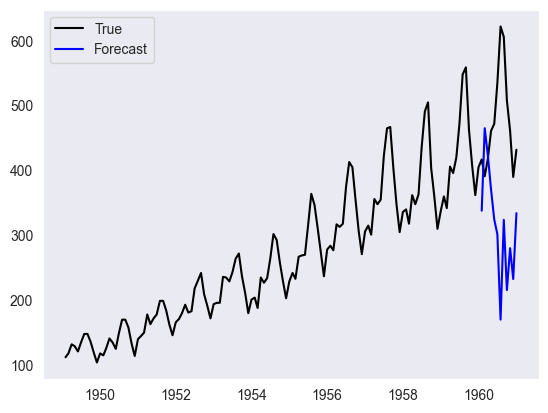

In [18]:
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['TimesNet-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['TimesNet-lo-90'][-12:].values, 
                    y2=plot_df['TimesNet-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['TimesNet'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()


## Getting Started

In [3]:
import pandas as pd
import io
import chardet

def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw = file.read()
    return chardet.detect(raw)['encoding']

def process_bike_rental_data(input_file, output_file):
    # Detect file encoding
    file_encoding = detect_encoding(input_file)
    print(f"Detected file encoding: {file_encoding}")

    # Read the file content
    with open(input_file, 'r', encoding=file_encoding, errors='replace') as file:
        content = file.read()

    # Use StringIO to create a file-like object from the string content
    string_io = io.StringIO(content)
    
    # Read the CSV file using pandas
    df = pd.read_csv(string_io)

    print("Original columns:", df.columns.tolist())
    print("Original shape:", df.shape)
    
    # Discard categorical columns
    columns_to_drop = ['Seasons', 'Holiday', 'Functioning Day']
    df = df.drop(columns=columns_to_drop)
    
    # Convert Date and Hour to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df['Date'] = df['Date'] + pd.to_timedelta(df['Hour'], unit='h')
    
    # Drop the Hour column as it's now integrated into Date
    df = df.drop(columns=['Hour'])
    
    # Reorder columns to have Date first
    columns = ['Date'] + [col for col in df.columns if col != 'Date']
    df = df[columns]
    
    # Save the processed DataFrame to a new CSV file
    df.to_csv(output_file, index=False)
    
    print(f"Processed data saved to {output_file}")
    print("Final columns:", df.columns.tolist())
    print("Final shape:", df.shape)
    
    return df

# Example usage:
input_file = '/Users/moji/PyTSF-MfG/data/SeoulBikeData.csv'  # Replace with your input file name
output_file = '/Users/moji/PyTSF-MfG/data/SeoulBikeData_processed.csv'  # Replace with your desired output file name

processed_df = process_bike_rental_data(input_file, output_file)

# Print the first few rows of the processed DataFrame
print("\nFirst few rows of the processed data:")
print(processed_df.head())

# Print summary statistics of the numeric data
print("\nSummary statistics of the numeric data:")
print(processed_df.describe())

Detected file encoding: ISO-8859-1
Original columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']
Original shape: (8760, 14)
Processed data saved to /Users/moji/PyTSF-MfG/data/SeoulBikeData_processed.csv
Final columns: ['Date', 'Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
Final shape: (8760, 10)

First few rows of the processed data:
                 Date  Rented Bike Count  Temperature(°C)  Humidity(%)  \
0 2017-12-01 00:00:00                254             -5.2           37   
1 2017-12-01 01:00:00                204             -5.5           38   
2 2017-12-01 02:00:00                173             -6.0           39   
3 2017-12-01 03:00:00           

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Read the CSV file
df = pd.read_csv('/Users/moji/PyTSF-MfG/data/energydata_complete.csv')

# Convert 'Date_Time' to datetime for time series analysis
df['Timestamp'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df.set_index('Timestamp', inplace=True)

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Time Series Visualizations
plt.figure(figsize=(20, 15))

# 1. Time Series of Energy Usage
plt.subplot(3, 1, 1)
df['Press_mm_hg'].plot()
plt.title('Time Series of Energy Usage')
plt.xlabel('Time')
plt.ylabel('Usage (kWh)')

# 2. Rolling statistics
window_size = 24 * 7  # One week
rolling_mean = df['Press_mm_hg'].rolling(window=window_size).mean()
rolling_std = df['Press_mm_hg'].rolling(window=window_size).std()

plt.subplot(3, 1, 2)
plt.plot(df.index, df['Press_mm_hg'], label='Energy Usage')
plt.plot(df.index, rolling_mean, label=f'Rolling Mean (window={window_size})')
plt.plot(df.index, rolling_std, label=f'Rolling Std (window={window_size})')
plt.title('Energy Usage - Rolling Statistics')
plt.legend()

# 3. Histogram of Energy Usage
plt.subplot(3, 1, 3)
df['Press_mm_hg'].hist(bins=50)
plt.title('Distribution of Energy Usage')
plt.xlabel('Usage (kWh)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Seasonal Decomposition
decomposition = seasonal_decompose(df['Press_mm_hg'], model='additive', period=24*7)  # Weekly seasonality

plt.figure(figsize=(12, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

# Autocorrelation and Partial Autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Press_mm_hg'].dropna(), ax=ax1, lags=24*7)
plot_pacf(df['Press_mm_hg'].dropna(), ax=ax2, lags=24*7)
plt.tight_layout()
plt.show()

# Correlation with other numeric variables
correlation = df[numeric_columns].corr()['Press_mm_hg'].sort_values(ascending=False)
print("Correlation with Energy Usage:")
print(correlation)

# Plot correlations
plt.figure(figsize=(10, 6))
correlation.plot(kind='bar')
plt.title('Feature Correlation with Energy Usage')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Time Series Forecasting Problem Definition
print("\nTime Series Forecasting Problem Definition:")
print("Target Variable: Usage_kWh")
print("Features: Historical values of Usage_kWh, and other numeric features")
print("Task: Predict future values of Usage_kWh based on historical data and other features")

# Basic statistics
print("\nBasic Statistics for Energy Usage:")
print(df['Press_mm_hg'].describe())

# Check for stationarity
result = adfuller(df['Press_mm_hg'].dropna())
print('\nAugmented Dickey-Fuller Test:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Print data types of all columns
print("\nData Types of Columns:")
print(df.dtypes)

# Print unique values in categorical columns
for column in df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in {column}:")
    print(df[column].unique())

# Additional analyses

# 1. Average energy usage by day of week
df['Day_Of_Week'] = df.index.day_name()
plt.figure(figsize=(10, 6))
df.groupby('Day_Of_Week')['Press_mm_hg'].mean().plot(kind='bar')
plt.title('Average Energy Usage by Day of Week')
plt.ylabel('Average Usage (kWh)')
plt.tight_layout()
plt.show()

# 2. Average energy usage by hour of day
df['Hour'] = df.index.hour
plt.figure(figsize=(12, 6))
df.groupby('Hour')['Press_mm_hg'].mean().plot()
plt.title('Average Energy Usage by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Usage (kWh)')
plt.tight_layout()
plt.show()

# 3. Energy usage heatmap (Day of Week vs Hour)
plt.figure(figsize=(12, 8))
usage_pivot = df.pivot_table(values='Press_mm_hg', index='Day_Of_Week', columns='Hour', aggfunc='mean')
sns.heatmap(usage_pivot, cmap='YlOrRd')
plt.title('Energy Usage Heatmap: Day of Week vs Hour')
plt.tight_layout()
plt.show()

# 4. Correlation heatmap for all numeric variables
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame with the 'Timestamp' index
# If not, uncomment and run these lines:
# df = pd.read_csv('/path/to/your/energy_consumption.csv')
# df['Timestamp'] = pd.to_datetime(df['Date_Time'], format='%d-%m-%Y %H:%M')
# df.set_index('Timestamp', inplace=True)

# Calculate the time difference between consecutive rows
time_diff = df.index.to_series().diff()

# Get the most common time difference
most_common_diff = time_diff.mode().iloc[0]

print(f"The most common time difference between data points is: {most_common_diff}")

# Check if all time differences are the same
if (time_diff == most_common_diff).all():
    print("The dataset has a consistent frequency.")
else:
    print("The dataset has some inconsistent time intervals.")

# Count the occurrences of each unique time difference
diff_counts = time_diff.value_counts()

print("\nCounts of unique time differences:")
print(diff_counts)

# Calculate the percentage of the most common difference
most_common_percentage = (diff_counts.iloc[0] / len(df)) * 100

print(f"\nPercentage of data points with the most common time difference: {most_common_percentage:.2f}%")

# If there are inconsistencies, show some examples
if len(diff_counts) > 1:
    print("\nExamples of inconsistent time intervals:")
    inconsistent = df[time_diff != most_common_diff]
    print(inconsistent.head())

# Visualize the distribution of time differences
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
time_diff.value_counts().plot(kind='bar')
plt.title('Distribution of Time Differences')
plt.xlabel('Time Difference')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Read the CSV file
df = pd.read_csv('/Users/moji/PyTSF-MfG/data/ai4i2020.csv')

# Convert 'UDI' to datetime for time series analysis
df['Timestamp'] = pd.to_datetime(df['UDI'], unit='s')  # Assuming UDI represents seconds
df.set_index('Timestamp', inplace=True)

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Time Series Visualizations
plt.figure(figsize=(20, 15))

# 1. Time Series of Rotational Speed
plt.subplot(3, 1, 1)
df['Rotational speed [rpm]'].plot()
plt.title('Time Series of Rotational Speed')
plt.xlabel('Time')
plt.ylabel('Rotational Speed [rpm]')

# 2. Rolling statistics
window_size = 30
rolling_mean = df['Rotational speed [rpm]'].rolling(window=window_size).mean()
rolling_std = df['Rotational speed [rpm]'].rolling(window=window_size).std()

plt.subplot(3, 1, 2)
plt.plot(df.index, df['Rotational speed [rpm]'], label='Rotational Speed')
plt.plot(df.index, rolling_mean, label=f'Rolling Mean (window={window_size})')
plt.plot(df.index, rolling_std, label=f'Rolling Std (window={window_size})')
plt.title('Rotational Speed - Rolling Statistics')
plt.legend()

# 3. Histogram of Rotational Speed
plt.subplot(3, 1, 3)
df['Rotational speed [rpm]'].hist(bins=50)
plt.title('Distribution of Rotational Speed')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Seasonal Decomposition
decomposition = seasonal_decompose(df['Rotational speed [rpm]'], model='additive', period=24)  # Assuming hourly data

plt.figure(figsize=(12, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

# Autocorrelation and Partial Autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Rotational speed [rpm]'].dropna(), ax=ax1, lags=50)
plot_pacf(df['Rotational speed [rpm]'].dropna(), ax=ax2, lags=50)
plt.tight_layout()
plt.show()

# Correlation with other numeric variables
correlation = df[numeric_columns].corr()['Rotational speed [rpm]'].sort_values(ascending=False)
print("Correlation with Rotational Speed:")
print(correlation)

# Plot correlations
plt.figure(figsize=(10, 6))
correlation.plot(kind='bar')
plt.title('Feature Correlation with Rotational Speed')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Time Series Forecasting Problem Definition
print("\nTime Series Forecasting Problem Definition:")
print("Target Variable: Rotational speed [rpm]")
print("Features: Historical values of Rotational speed [rpm], and other numeric features")
print("Task: Predict future values of Rotational speed [rpm] based on historical data and other features")
print("Potential Models: ARIMA, SARIMA, Prophet, or machine learning models like Random Forest, XGBoost, or LSTM")

# Basic statistics
print("\nBasic Statistics for Rotational Speed:")
print(df['Rotational speed [rpm]'].describe())

# Check for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Rotational speed [rpm]'].dropna())
print('\nAugmented Dickey-Fuller Test:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Print data types of all columns
print("\nData Types of Columns:")
print(df.dtypes)

# Print unique values in non-numeric columns
for column in df.select_dtypes(exclude=[np.number]).columns:
    print(f"\nUnique values in {column}:")
    print(df[column].unique())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Read the CSV file
df = pd.read_csv('/Users/moji/Downloads/ai4i2020.csv')

# Convert 'UDI' to datetime for time series analysis
df['Timestamp'] = pd.to_datetime(df['UDI'], unit='s')  # Assuming UDI represents seconds
df.set_index('Timestamp', inplace=True)

# Select variables for analysis
variables = ['Rotational speed [rpm]', 'Air temperature [K]', 'Process temperature [K]']

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Time Series Visualizations
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
fig.suptitle('Time Series Comparison', fontsize=16)

for i, var in enumerate(variables):
    axes[i].plot(df.index, df[var])
    axes[i].set_title(f'Time Series of {var}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

# Rolling Statistics
window_size = 30
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
fig.suptitle('Rolling Statistics Comparison', fontsize=16)

for i, var in enumerate(variables):
    rolling_mean = df[var].rolling(window=window_size).mean()
    rolling_std = df[var].rolling(window=window_size).std()
    
    axes[i].plot(df.index, df[var], label=var)
    axes[i].plot(df.index, rolling_mean, label=f'Rolling Mean (window={window_size})')
    axes[i].plot(df.index, rolling_std, label=f'Rolling Std (window={window_size})')
    axes[i].set_title(f'{var} - Rolling Statistics')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Histograms
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distribution Comparison', fontsize=16)

for i, var in enumerate(variables):
    axes[i].hist(df[var], bins=50)
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Seasonal Decomposition
for var in variables:
    decomposition = seasonal_decompose(df[var], model='additive', period=24)  # Assuming hourly data
    plt.figure(figsize=(12, 10))
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition of {var}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Autocorrelation and Partial Autocorrelation
for var in variables:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df[var].dropna(), ax=ax1, lags=50)
    plot_pacf(df[var].dropna(), ax=ax2, lags=50)
    plt.suptitle(f'ACF and PACF of {var}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Correlation Analysis
correlation_matrix = df[variables].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Time Series Forecasting Problem Definition
print("\nTime Series Forecasting Problem Definition:")
for var in variables:
    print(f"\nTarget Variable: {var}")
    print(f"Features: Historical values of {var}, and other relevant numeric variables")
    print(f"Task: Predict future values of {var} based on historical data and other features")
    print("Potential Models: ARIMA, SARIMA, Prophet, or machine learning models like Random Forest, XGBoost, or LSTM")

# Basic statistics and stationarity test
for var in variables:
    print(f"\nBasic Statistics for {var}:")
    print(df[var].describe())
    
    result = adfuller(df[var].dropna())
    print(f'\nAugmented Dickey-Fuller Test for {var}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Correlation with other numeric variables
for var in variables:
    correlation = df[numeric_columns].corr()[var].sort_values(ascending=False)
    print(f"\nCorrelation with {var}:")
    print(correlation)

    plt.figure(figsize=(10, 6))
    correlation.plot(kind='bar')
    plt.title(f'Feature Correlation with {var}')
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Print data types of all columns
print("\nData Types of Columns:")
print(df.dtypes)

# Print unique values in non-numeric columns
for column in df.select_dtypes(exclude=[np.number]).columns:
    print(f"\nUnique values in {column}:")
    print(df[column].unique())

In [ ]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF # Defined in neuralforecast.utils
Y_df.head()

### Important:
* DataFrames must include all ['unique_id', 'ds', 'y'] columns. Make sure y column does not have missing or non-numeric values.

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN

In [ ]:
horizon = 12

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_df)


In [ ]:
Y_hat_df = nf.predict() #obtain the h forecasts after the training data Y_df.

In [ ]:
Y_hat_df

In [ ]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


## Data Inputs

In [ ]:
import pandas as pd
from datasetsforecast.m3 import M3

In [ ]:
Y_df, *_ = M3.load('./data', group='Yearly')

In [ ]:
Y_df.groupby('unique_id').head(2)

## Exogenous Variables

* Static exogenous variables: The static exogenous variables carry time-invariant information for each time series. When the model is built with global parameters to forecast multiple time series, these variables allow sharing information within groups of time series with similar static variable levels. Examples of static variables include designators such as identifiers of regions, groups of products, etc.

* Historic exogenous variables: This time-dependent exogenous variable is restricted to past observed values. Its predictive power depends on Granger-causality, as its past values can provide significant information about future values of the target variable y

* Future exogenous variables: In contrast with historic exogenous variables, future values are available at the time of the prediction. Examples include calendar variables, weather forecasts, and known events that can cause large spikes and dips such as scheduled promotions.

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE.csv')
df['ds'] = pd.to_datetime(df['ds'])
df.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df[df['unique_id']=='FR']['ds'], df[df['unique_id']=='FR']['y'])
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')
plt.grid()

In [ ]:
static_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE_static.csv')
static_df.head()

In [ ]:
from neuralforecast.auto import NHITS, BiTCN
from neuralforecast.core import NeuralForecast

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
horizon = 24 # day-ahead daily forecast
models = [NHITS(h = horizon,
                input_size = 5*horizon,
                futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                hist_exog_list = ['system_load'], # <- Historical exogenous variables
                stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                scaler_type = 'robust'),
          BiTCN(h = horizon,
                input_size = 5*horizon,
                futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                hist_exog_list = ['system_load'], # <- Historical exogenous variables
                stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                scaler_type = 'robust',
                ),                
                ]


In [ ]:
nf = NeuralForecast(models=models, freq='H')
nf.fit(df=df,
       static_df=static_df)


In [ ]:
futr_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE_futr.csv')
futr_df['ds'] = pd.to_datetime(futr_df['ds'])
futr_df.head()


In [ ]:
Y_hat_df = nf.predict(futr_df=futr_df)
Y_hat_df.head()

In [ ]:
import matplotlib.pyplot as plt

plot_df = df[df['unique_id']=='FR'].tail(24*5).reset_index(drop=True)
Y_hat_df = Y_hat_df.reset_index(drop=False)
Y_hat_df = Y_hat_df[Y_hat_df['unique_id']=='FR']

plot_df = pd.concat([plot_df, Y_hat_df ]).set_index('ds') # Concatenate the train and forecast dataframes

plot_df[['y', 'NHITS', 'BiTCN']].plot(linewidth=2)
plt.axvline('2016-11-01', color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid()


## Time Series Scaling

The Neuralforecast library integrates two types of temporal scaling:

* Time Series Scaling: scaling each time series using all its data on the train set before start training the model. This is done by using the "local_scaler_type" parameter of the Neuralforecast core class. local_scaler_type parameter is used to specify the type of scaling to be used. In this case, we will use standard, which scales the data to have zero mean and unit variance.Other supported scalers are minmax, robust, robust-iqr, minmax, and boxcox.

* Window scaling (TemporalNorm): scaling each input window separetly for each element of the batch at every training iteration. This is done by using the "scaler_type" parameter of each model class. Temporal normalization is specified by the scaler_type argument. Currently, it is only supported for Windows-based models (NHITS, NBEATS, MLP, TimesNet, and all Transformers).

## Hyperparameter Optimization
The main steps of hyperparameter tuning are:

* 1- Define training and validation sets.
* 2- Define search space.
* 3- Sample configurations with a search algorithm, train models, and evaluate them on the validation set.
* 4- Select and store the best model.

In [ ]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF
Y_df.head()


In [ ]:
#complete

## End to End Walkthrough
Outline:

* 1- Install packages.
* 2- Read the data.
* 3- Explore the data.
* 4- Train many models globally for the entire dataset.
* 5- Evaluate the model’s performance using cross-validation.
* 6- Select the best model for every unique time series.

The input to NeuralForecast is always a data frame in long format with three columns: unique_id, ds and y:

In [ ]:
import pandas as pd

Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

Y_df.head()


In [ ]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)


In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(Y_df, engine='matplotlib')


In [ ]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [ ]:
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}


In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq=1
)


In [ ]:
nf.fit(df=Y_df)

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()


In [ ]:
# Plot to unique_ids and some selected models
StatsForecast.plot(Y_df, fcst_df, models=["AutoLSTM"], unique_ids=["H107", "H104"], level=[80, 90], engine='matplotlib')


In [ ]:
cv_df = nf.cross_validation(Y_df, n_windows=2)


In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')


In [ ]:
cv_df.head()


In [ ]:
for cutoff in cv_df['cutoff'].unique():
    StatsForecast.plot(
        Y_df, 
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
        max_insample_length=48 * 4, 
        unique_ids=['H185'],
        engine='matplotlib'
    )


In [ ]:
from datasetsforecast.losses import mse, mae, rmse
from datasetsforecast.evaluation import accuracy


In [ ]:
evaluation_df = accuracy(cv_df, [mse, mae, rmse], agg_by=['unique_id'])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()
